# 0. Downloading the spider dataset and store on google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/MyDrive/colab_data"

spider_results	spider.zip


--- STEP 1: Unzipping spider.zip ---
-> Extracting internal archive: images.zip...
-> Extracting internal archive: masks.zip...

--- STEP 2: Tabular Data Analysis (CSV) ---

[overview.csv] - Shape: (447, 39)


,new_file_name,num_vertebrae,num_discs,sex,birth_date,subset,AngioFlag,BodyPartExamined,DeviceSerialNumber,EchoNumbers,...,ScanningSequence,SequenceName,SeriesDescription,SliceThickness,SoftwareVersions,SpacingBetweenSlices,SpecificCharacterSet,TransmitCoilName,WindowCenter,WindowWidth
0,1_t1,7,7,F,NaN,training,NaN,LSPINE,NaN,1,...,SE,NaN,NaN,3.0,"['5.6.1', '5.6.1.2']",3.3,ISO 2022 IR 100,NaN,1093.0,1901.0
1,1_t2,7,7,F,NaN,training,NaN,LSPINE,NaN,1,...,SE,NaN,NaN,3.0,"['5.6.1', '5.6.1.2']",3.3,ISO 2022 IR 100,NaN,1026.0,1784.0
2,10_t1,7,7,F,NaN,training,N,LSPINE,170042.0,1,...,SE,*tse2d1_5,SAG T1 TSE,4.0,syngo MR E11,4.4,ISO_IR 100,Body,598.0,1281.0



[radiological_gradings.csv] - Shape: (1520, 10)


,Patient,IVD label,Modic,UP endplate,LOW endplate,Spondylolisthesis,Disc herniation,Disc narrowing,Disc bulging,Pfirrman grade
0,1,1,0,0,0,0,0,1,1,3
1,1,2,0,0,0,0,0,0,1,3
2,1,3,0,0,0,0,0,1,1,3



Diagnosis Distribution (Lumbar Disc Herniation):
Disc herniation
0    1448
1      72
Name: count, dtype: int64

--- STEP 3: Indexing MRI and Mask Files ---
Found MRI images: 447
Found Masks: 447
Complete Pairs (MRI + Mask): 447

--- STEP 4: Visualizing Random Case (3 Views) ---
Selected File: 182_t1.mha
MRI Path: ./spider_data/images/images/182_t1.mha


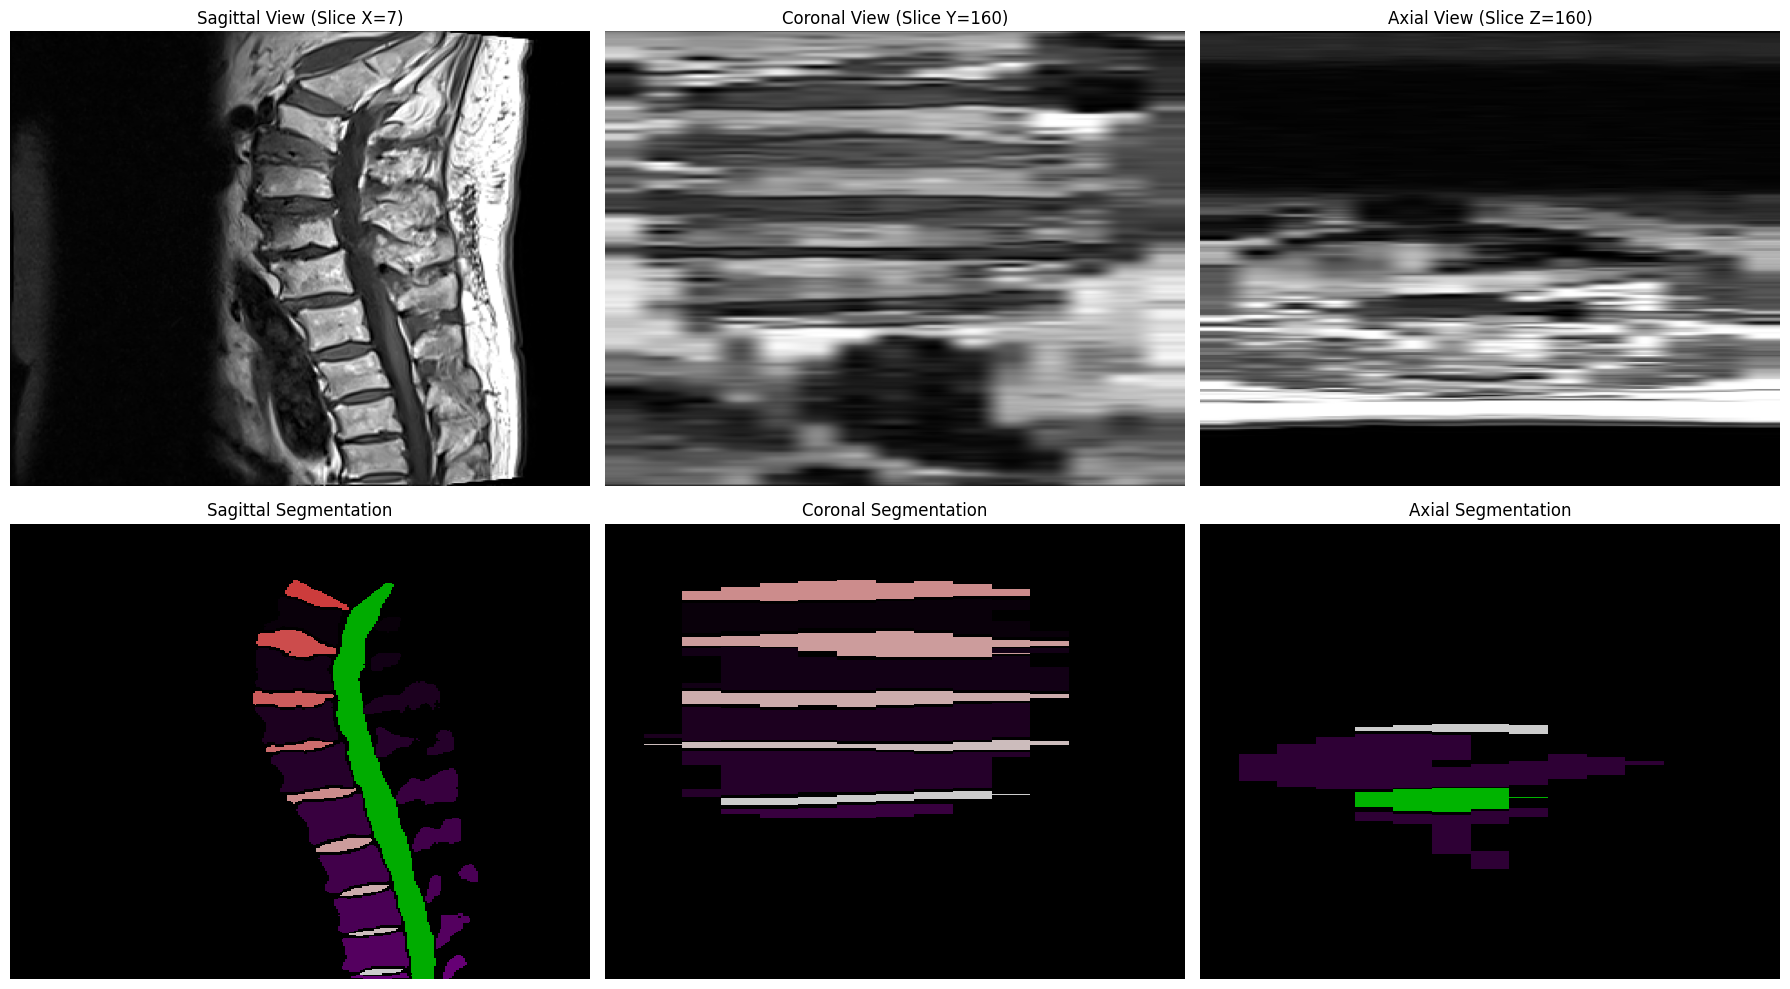


LEGEND:
Row 1: Raw MRI scans (Sagittal, Coronal, Axial)
Row 2: Segmentation masks (Colors represent Vertebrae, Discs, and Canal)


In [6]:
# ==========================================
# COMPLETE SPIDER DATASET EDA
# ==========================================

import os
import zipfile
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import random

# Configuration
ZIP_PATH = '/content/drive/MyDrive/colab_data/spider.zip'
EXTRACT_PATH = './spider_data'

# ==========================================
# STEP 1: UNZIPPING DATA
# ==========================================
print(f"--- STEP 1: Unzipping {os.path.basename(ZIP_PATH)} ---")

if os.path.exists(ZIP_PATH):
    # Extract main zip
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

    # Extract nested archives (images.zip and masks.zip) if they exist
    for sub_zip in ['images.zip', 'masks.zip']:
        sub_zip_path = os.path.join(EXTRACT_PATH, sub_zip)
        if os.path.exists(sub_zip_path):
            print(f"-> Extracting internal archive: {sub_zip}...")
            target_dir = os.path.join(EXTRACT_PATH, sub_zip.replace('.zip', ''))
            with zipfile.ZipFile(sub_zip_path, 'r') as z:
                z.extractall(target_dir)
else:
    print(f"ERROR: File {ZIP_PATH} not found. Please check the path.")

# ==========================================
# STEP 2: CSV ANALYSIS
# ==========================================
print(f"\n--- STEP 2: Tabular Data Analysis (CSV) ---")

overview_csv = os.path.join(EXTRACT_PATH, 'overview.csv')
grading_csv = os.path.join(EXTRACT_PATH, 'radiological_gradings.csv')

if os.path.exists(overview_csv):
    df_over = pd.read_csv(overview_csv)
    print(f"\n[overview.csv] - Shape: {df_over.shape}")
    display(df_over.head(3))
else:
    print("Warning: overview.csv not found.")

if os.path.exists(grading_csv):
    df_grad = pd.read_csv(grading_csv)
    print(f"\n[radiological_gradings.csv] - Shape: {df_grad.shape}")
    display(df_grad.head(3))

    # Quick distribution check
    print("\nDiagnosis Distribution (Lumbar Disc Herniation):")
    if 'Disc herniation' in df_grad.columns:
        print(df_grad['Disc herniation'].value_counts().head())
else:
    print("Warning: radiological_gradings.csv not found.")

# ==========================================
# STEP 3: MAPPING IMAGES AND MASKS
# ==========================================
print(f"\n--- STEP 3: Indexing MRI and Mask Files ---")

image_map = {} # Dictionary: {filename: full_path}
mask_map = {}
for root, dirs, files in os.walk(EXTRACT_PATH):
    for file in files:
        if file.endswith('.mha'):
            full_path = os.path.join(root, file)
            if 'mask' in full_path.lower():
                mask_map[file] = full_path
            elif 'image' in full_path.lower():
                image_map[file] = full_path

print(f"Found MRI images: {len(image_map)}")
print(f"Found Masks: {len(mask_map)}")

# Find intersection (files that exist in both)
common_files = list(set(image_map.keys()) & set(mask_map.keys()))
print(f"Complete Pairs (MRI + Mask): {len(common_files)}")

# ==========================================
# STEP 4: VISUALIZATION
# ==========================================
print(f"\n--- STEP 4: Visualizing Random Case (3 Views) ---")

if common_files:
    # 1. Select random file
    selected_filename = random.choice(common_files)
    img_path = image_map[selected_filename]
    msk_path = mask_map[selected_filename]

    print(f"Selected File: {selected_filename}")
    print(f"MRI Path: {img_path}")
    img_sitk = sitk.ReadImage(img_path)
    msk_sitk = sitk.ReadImage(msk_path)
    img_arr = sitk.GetArrayFromImage(img_sitk)
    msk_arr = sitk.GetArrayFromImage(msk_sitk)
    d, h, w = img_arr.shape
    mid_d, mid_h, mid_w = d // 2, h // 2, w // 2

    # 4. Plotting - Using aspect='auto' to fix "squashed" images
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # --- ROW 1: MRI IMAGES ---

    # Sagittal View (Side view - usually the most important for spine)
    axes[0, 0].imshow(img_arr[:, :, mid_w], cmap='gray', aspect='auto')
    axes[0, 0].set_title(f"Sagittal View (Slice X={mid_w})")
    axes[0, 0].axis('off')

    # Coronal View (Front view)
    axes[0, 1].imshow(img_arr[:, mid_h, :], cmap='gray', aspect='auto')
    axes[0, 1].set_title(f"Coronal View (Slice Y={mid_h})")
    axes[0, 1].axis('off')

    # Axial View (Top-down view)
    axes[0, 2].imshow(img_arr[mid_d, :, :], cmap='gray', aspect='auto')
    axes[0, 2].set_title(f"Axial View (Slice Z={mid_d})")
    axes[0, 2].axis('off')

    # --- ROW 2: SEGMENTATION MASKS ---

    # Sagittal Mask
    axes[1, 0].imshow(msk_arr[:, :, mid_w], cmap='nipy_spectral', interpolation='nearest', aspect='auto')
    axes[1, 0].set_title("Sagittal Segmentation")
    axes[1, 0].axis('off')

    # Coronal Mask
    axes[1, 1].imshow(msk_arr[:, mid_h, :], cmap='nipy_spectral', interpolation='nearest', aspect='auto')
    axes[1, 1].set_title("Coronal Segmentation")
    axes[1, 1].axis('off')

    # Axial Mask
    axes[1, 2].imshow(msk_arr[mid_d, :, :], cmap='nipy_spectral', interpolation='nearest', aspect='auto')
    axes[1, 2].set_title("Axial Segmentation")
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\nLEGEND:")
    print("Row 1: Raw MRI scans (Sagittal, Coronal, Axial)")
    print("Row 2: Segmentation masks (Colors represent Vertebrae, Discs, and Canal)")

else:
    print("ERROR: No matching image-mask pairs found. Please check file structure.")

# 1. Preprocessing for Trening

In [7]:
import os
import cv2
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
from utilis import normalize_mri, get_bbox_from_mask, get_grade

INPUT_DIR = './spider_data'
OUTPUT_DIR = './processed_dataset'
IMG_SIZE = 512  # size 512x512

folders = [
    'segmentation/images', 'segmentation/masks', # for models
    'detection/images', 'detection/labels'
]

for f in folders:
    os.makedirs(os.path.join(OUTPUT_DIR, f), exist_ok=True)

# === RUN ===

image_files = [f for f in os.listdir(os.path.join(INPUT_DIR, 'images/images')) if f.endswith('.mha')]

print(f"Loading {len(image_files)} MRI volumes...")

for filename in tqdm(image_files):
    img_path = os.path.join(INPUT_DIR, 'images/images', filename)
    mask_path = os.path.join(INPUT_DIR, 'masks/masks', filename)

    if not os.path.exists(mask_path): continue

    # ITK load
    itk_img = sitk.ReadImage(img_path)
    itk_mask = sitk.ReadImage(mask_path)

    arr_img = sitk.GetArrayFromImage(itk_img)  # (Z, Y, X)
    arr_mask = sitk.GetArrayFromImage(itk_mask)

    depth, height, width = arr_img.shape
    mid_slice = width // 2
    slices_to_take = range(mid_slice - 2, mid_slice + 3)

    for s_idx in slices_to_take:
        # plaster getter
        slice_img = arr_img[:, :, s_idx]
        slice_mask = arr_mask[:, :, s_idx]

        # Normalize and Resize
        slice_img_norm = normalize_mri(slice_img)

        # Resize do 512x512
        slice_img_resized = cv2.resize(slice_img_norm, (IMG_SIZE, IMG_SIZE))
        slice_mask_resized = cv2.resize(slice_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        # === CLASS MAPPING ===
        # YOLO converter
        unique_labels = np.unique(slice_mask_resized)
        yolo_labels = []
        relevant_labels = [l for l in unique_labels if l > 0]

        for label in relevant_labels:
            class_id = 0

            bbox = get_bbox_from_mask(slice_mask_resized, label)
            if bbox:
                yolo_labels.append(bbox)

        # Save images
        base_name = f"{filename.replace('.mha', '')}_slice{s_idx}"
        save_img_path = os.path.join(OUTPUT_DIR, 'segmentation/images', base_name + ".png")
        cv2.imwrite(save_img_path, slice_img_resized)
        cv2.imwrite(os.path.join(OUTPUT_DIR, 'detection/images', base_name + ".jpg"), slice_img_resized)
        cv2.imwrite(os.path.join(OUTPUT_DIR, 'segmentation/masks', base_name + ".png"), slice_mask_resized)

        # 3. (for YOLO)
        if yolo_labels:
            with open(os.path.join(OUTPUT_DIR, 'detection/labels', base_name + ".txt"), 'w') as f:
                f.write("\n".join(yolo_labels))

print("Gotowe! Dane przygotowane w folderze ./processed_dataset")

Przetwarzanie 447 wolumenów MRI...


100%|██████████| 447/447 [01:56<00:00,  3.82it/s]

Gotowe! Dane przygotowane w folderze ./processed_dataset


# 2. YOLO based segmentation

In [8]:
import os
import shutil
import random
from pathlib import Path

BASE_DIR = './processed_dataset/detection'
TRAIN_DIR = './datasets/spider_yolo/train'
VAL_DIR = './datasets/spider_yolo/val'

for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(d, 'images'), exist_ok=True)
    os.makedirs(os.path.join(d, 'labels'), exist_ok=True)


images = [f for f in os.listdir(os.path.join(BASE_DIR, 'images')) if f.endswith('.jpg')]
random.shuffle(images)

# 80/20 split
split_idx = int(len(images) * 0.8)
train_imgs = images[:split_idx]
val_imgs = images[split_idx:]

def move_files(file_list, source_dir, dest_dir):
    for img_name in file_list:
        src_img = os.path.join(source_dir, 'images', img_name)
        dst_img = os.path.join(dest_dir, 'images', img_name)
        shutil.copy(src_img, dst_img)

        txt_name = img_name.replace('.jpg', '.txt')
        src_txt = os.path.join(source_dir, 'labels', txt_name)
        dst_txt = os.path.join(dest_dir, 'labels', txt_name)

        if os.path.exists(src_txt):
            shutil.copy(src_txt, dst_txt)

print("Images to YOLO structure...")
move_files(train_imgs, BASE_DIR, TRAIN_DIR)
move_files(val_imgs, BASE_DIR, VAL_DIR)
print(f"Ready! Train: {len(train_imgs)}, Val: {len(val_imgs)}")

Przenoszenie plików do struktury YOLO...
Gotowe! Train: 1788, Val: 447


## Mapping for YOLO

In [9]:
import os
import glob
from tqdm import tqdm

LABELS_DIR = './datasets/spider_yolo'

def remap_class_id(original_id):
    oid = int(original_id)

    # mapping logic
    if 1 <= oid <= 50:
        return 0  # Klasa 0: (Vertebra)
    elif oid == 100:
        return 1  # Klasa 1: (Spinal Canal)
    elif oid >= 200:
        return 2  # Klasa 2: (IVD)
    else:
        return -1 # Not known

txt_files = glob.glob(os.path.join(LABELS_DIR, '**/*.txt'), recursive=True)

print(f"Fixing {len(txt_files)} files...")

for txt_path in tqdm(txt_files):
    new_lines = []
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue

        original_id = parts[0]
        coords = parts[1:]

        new_id = remap_class_id(original_id)

        if new_id != -1:
            new_line = f"{new_id} {' '.join(coords)}\n"
            new_lines.append(new_line)

    with open(txt_path, 'w') as f:
        f.writelines(new_lines)

print("Ready! ID fixed to 0, 1, 2.")

Naprawianie 2225 plików tekstowych...


100%|██████████| 2225/2225 [00:00<00:00, 6743.49it/s]

Gotowe! ID zostały zamienione na 0, 1, 2.


## Creating YOLO model

In [10]:
import yaml

data_yaml = {
    'path': '/content/datasets/spider_yolo',
    'train': 'train/images',
    'val': 'val/images',
    'nc': 3,
    'names': {
        0: 'Vertebra',
        1: 'Spinal Canal',
        2: 'Disc'
    }
}

with open('spider_final.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

Plik konfiguracyjny zaktualizowany.


In [11]:
from ultralytics import YOLO

# Read model
model = YOLO('yolov8n.pt')

results = model.train(
    data='spider_final.yaml',
    epochs=15,
    imgsz=512,
    batch=16,
    name='spider_yolo_final'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=spider_final.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=Fal

## YOLO localization task performance

Testowanie na: ./datasets/spider_yolo/val/images/172_t1_slice16.jpg

image 1/1 /content/datasets/spider_yolo/val/images/172_t1_slice16.jpg: 512x512 6 Vertebras, 1 Spinal Canal, 6 Discs, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict2


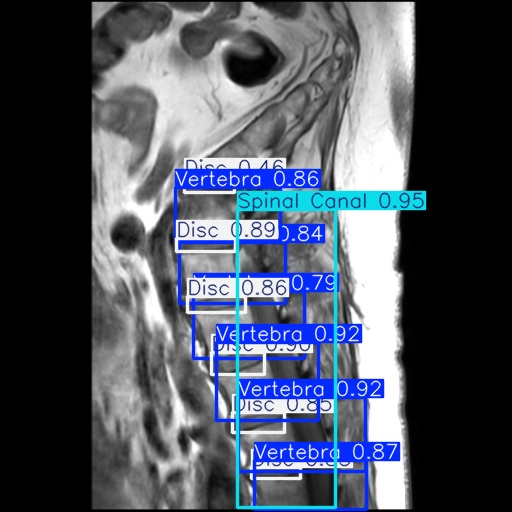

In [12]:
from IPython.display import Image, display
import glob

val_images = glob.glob('./datasets/spider_yolo/val/images/*.jpg')
test_img = val_images[0]

print(f"Testowanie na: {test_img}")
results = model.predict(source=test_img, save=True, conf=0.25)
latest_run = max(glob.glob('runs/detect/*'), key=os.path.getmtime)
saved_img_path = os.path.join(latest_run, os.path.basename(test_img))

display(Image(filename=saved_img_path))

# 3. Creating dataset with locations, ready for grading

In [14]:
import os
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm
import glob
import shutil

# === KONFIGURACJA ===
YOLO_DATASET_DIR = './datasets/spider_yolo'
CSV_PATH = './spider_data/radiological_gradings.csv'
OUTPUT_DIR = './dataset_grading'

list_of_files = glob.glob('runs/detect/*/weights/best.pt')
if not list_of_files:
    raise FileNotFoundError("not found best.pt!")

latest_model_path = max(list_of_files, key=os.path.getmtime)
print(f"✅ Using model: {latest_model_path}")
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
for i in range(1, 6): os.makedirs(os.path.join(OUTPUT_DIR, str(i)), exist_ok=True)

# 3. Loading
model = YOLO(latest_model_path)
df_grads = pd.read_csv(CSV_PATH)

# Id class check
DISC_ID = 2
for k, v in model.names.items():
    if 'disc' in v.lower():
        DISC_ID = k
        break
print(f"Looking for 'Disc' ID: {DISC_ID}")

## RUN
all_images = glob.glob(os.path.join(YOLO_DATASET_DIR, '**/*.jpg'), recursive=True)
print(f"🚀 Przetwarzanie {len(all_images)} zdjęć...")

saved_count = 0

for img_path in tqdm(all_images):
    filename = os.path.basename(img_path)
    try: patient_id = filename.split('_')[0]
    except: continue

    # pred
    results = model.predict(img_path, conf=0.15, verbose=False, imgsz=512)[0]
    boxes = results.boxes.data.cpu().numpy()
    disc_boxes = [b for b in boxes if int(b[5]) == DISC_ID]
    if not disc_boxes: continue

    # sort
    disc_boxes.sort(key=lambda x: x[1])

    # load
    img = cv2.imread(img_path)
    if img is None: continue
    h, w, _ = img.shape

    # Each disc splitting
    for i, box in enumerate(disc_boxes):
        x1, y1, x2, y2 = map(int, box[:4])

        grade = get_grade(patient_id, i)

        if grade and 1 <= grade <= 5:
            # Margines 10%
            pad_x = int((x2-x1) * 0.1)
            pad_y = int((y2-y1) * 0.1)

            x1 = max(0, x1 - pad_x); x2 = min(w, x2 + pad_x)
            y1 = max(0, y1 - pad_y); y2 = min(h, y2 + pad_y)

            crop = img[y1:y2, x1:x2]

            if crop.size > 0:
                crop = cv2.resize(crop, (224, 224))
                sname = f"{patient_id}_s{filename.split('slice')[-1].replace('.jpg','')}_d{i+1}.jpg"
                save_p = os.path.join(OUTPUT_DIR, str(grade), sname)
                cv2.imwrite(save_p, crop)
                saved_count += 1

print(f"Discs ready for grading: {saved_count}")

✅ Używam modelu: runs/detect/spider_yolo_final/weights/best.pt
ℹ️  Szukam klasy 'Disc' pod ID: 2
🚀 Przetwarzanie 2235 zdjęć...


100%|██████████| 2235/2235 [00:45<00:00, 48.97it/s]


✅ ZAKOŃCZONO!
Liczba wyciętych dysków przygotowanych do gradingu: 14491


# 4. ResNet18 vs EffNet-B0 for grading

Używam urządzenia: cuda
Znaleziono klasy: ['1', '2', '3', '4', '5'] (Łącznie: 5)
Trening: 6416, Walidacja: 1605
Wagi klas (dla Loss Function): tensor([0.0009, 0.0007, 0.0006, 0.0008, 0.0012], device='cuda:0')

Przygotowanie ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]



--- Trenowanie: ResNet18 ---
Epoch 1/20 | val Loss: 1.1603 Acc: 0.4480
Epoch 2/20 | val Loss: 1.1270 Acc: 0.5065
Epoch 3/20 | val Loss: 1.1220 Acc: 0.4766
Epoch 4/20 | val Loss: 1.0851 Acc: 0.5165
Epoch 5/20 | val Loss: 1.0754 Acc: 0.5090
Epoch 6/20 | val Loss: 1.0611 Acc: 0.5414
Epoch 7/20 | val Loss: 1.0706 Acc: 0.5358
Epoch 8/20 | val Loss: 0.9589 Acc: 0.5863
Epoch 9/20 | val Loss: 0.9531 Acc: 0.5900
Epoch 10/20 | val Loss: 0.9460 Acc: 0.6006
Epoch 11/20 | val Loss: 0.9103 Acc: 0.6031
Epoch 12/20 | val Loss: 0.9423 Acc: 0.6224
Epoch 13/20 | val Loss: 0.9287 Acc: 0.6368
Epoch 14/20 | val Loss: 0.9110 Acc: 0.6355
Epoch 15/20 | val Loss: 0.9033 Acc: 0.6511
Epoch 16/20 | val Loss: 0.9079 Acc: 0.6517
Epoch 17/20 | val Loss: 0.9086 Acc: 0.6548
Epoch 18/20 | val Loss: 0.8996 Acc: 0.6511
Epoch 19/20 | val Loss: 0.9046 Acc: 0.6598
Epoch 20/20 | val Loss: 0.9038 Acc: 0.6517
ResNet18 Best Val Acc: 0.6598

Przygotowanie EfficientNet-B0...
Downloading: "https://download.pytorch.org/models/effic

100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]



--- Trenowanie: EfficientNet-B0 ---
Epoch 1/20 | val Loss: 1.1282 Acc: 0.5078
Epoch 2/20 | val Loss: 1.0429 Acc: 0.5545
Epoch 3/20 | val Loss: 1.0442 Acc: 0.5495
Epoch 4/20 | val Loss: 1.0633 Acc: 0.5570
Epoch 5/20 | val Loss: 0.8909 Acc: 0.6187
Epoch 6/20 | val Loss: 0.9639 Acc: 0.6143
Epoch 7/20 | val Loss: 0.9517 Acc: 0.6199
Epoch 8/20 | val Loss: 0.8168 Acc: 0.6773
Epoch 9/20 | val Loss: 0.8157 Acc: 0.6816
Epoch 10/20 | val Loss: 0.8176 Acc: 0.6891
Epoch 11/20 | val Loss: 0.8386 Acc: 0.6947
Epoch 12/20 | val Loss: 0.8542 Acc: 0.7028
Epoch 13/20 | val Loss: 0.8536 Acc: 0.7009
Epoch 14/20 | val Loss: 0.8697 Acc: 0.7134
Epoch 15/20 | val Loss: 0.8631 Acc: 0.7078
Epoch 16/20 | val Loss: 0.8648 Acc: 0.7072
Epoch 17/20 | val Loss: 0.8775 Acc: 0.7165
Epoch 18/20 | val Loss: 0.8722 Acc: 0.7072
Epoch 19/20 | val Loss: 0.8651 Acc: 0.7128
Epoch 20/20 | val Loss: 0.8699 Acc: 0.7128
EfficientNet-B0 Best Val Acc: 0.7165


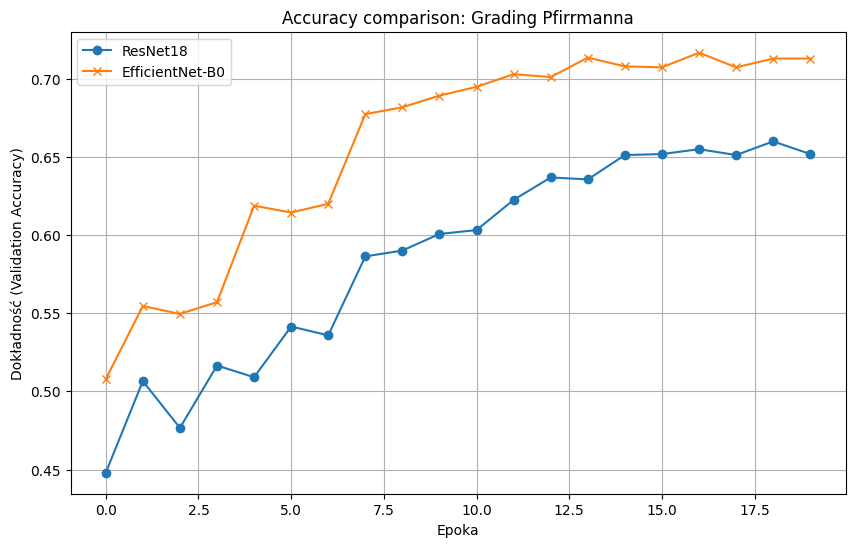

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import copy

DATA_DIR = './dataset_grading'
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam urządzenia: {DEVICE}")

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data load
try:
    base_dataset = datasets.ImageFolder(DATA_DIR)
    classes = base_dataset.classes
    num_classes = len(classes)
    print(f"Znaleziono klasy: {classes} (Łącznie: {num_classes})")

    targets = base_dataset.targets
    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2,
        shuffle=True,
        stratify=targets
    )

    train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
    val_dataset = datasets.ImageFolder(DATA_DIR, transform=val_transforms)

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)

    print(f"Trening: {len(train_subset)}, Walidacja: {len(val_subset)}")

    # Balancing
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets)
    class_weights = 1. / class_counts
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)
    print(f"Wages (for Loss Function): {class_weights}")

except FileNotFoundError:
    print("error: dataset_grading empty")
    raise

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
}
dataset_sizes = {'train': len(train_subset), 'val': len(val_subset)}

def train_model(model, name):
    print(f"\n--- Trenowanie: {name} ---")
    model = model.to(DEVICE)

    # wages for loss
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    acc_history = []
    best_acc = 0.0

    for epoch in range(EPOCHS):
      # valid and train
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                print(f'Epoch {epoch+1}/{EPOCHS} | {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'{name} Best Val Acc: {best_acc:.4f}')
    return acc_history

# === 4. RUN ===

# --- ResNet18 ---
print("\nPrzygotowanie ResNet18...")
resnet = models.resnet18(weights='DEFAULT')
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
hist_resnet = train_model(resnet, "ResNet18")

# --- EfficientNet B0 ---
print("\nPrzygotowanie EfficientNet-B0...")
effnet = models.efficientnet_b0(weights='DEFAULT')
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)
hist_effnet = train_model(effnet, "EfficientNet-B0")

# === 5. results ===
plt.figure(figsize=(10, 6))
plt.plot(hist_resnet, label='ResNet18', marker='o')
plt.plot(hist_effnet, label='EfficientNet-B0', marker='x')
plt.title('Accuracy comparison: Grading Pfirrmanna')
plt.xlabel('Epoka')
plt.ylabel('(Validation Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

## Augmentation


=== PRZYKŁADOWE OBRAZY TRENINGOWE (PO AUGMENTACJI) ===


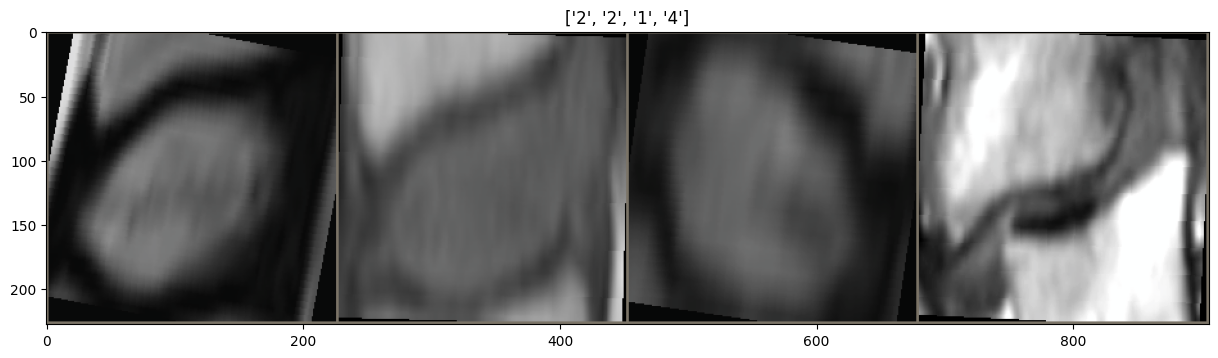

In [16]:
import torchvision
from utilis import imshow
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:4])
class_names = base_dataset.classes

print("\n=== PRZYKŁADOWE OBRAZY TRENINGOWE (AFTER AUGMENTACJI) ===")
plt.figure(figsize=(15, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

# 5. Conf matrix ResNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Foldery utworzone w: /content/drive/MyDrive/colab_data/spider_results/
Używam modelu: runs/detect/spider_yolo_final/weights/best.pt
Zapisywanie 10 przykładów detekcji do: /content/drive/MyDrive/colab_data/spider_results/localization_yolo ...

image 1/1 /content/datasets/spider_yolo/val/images/20_t2_slice11.jpg: 512x512 7 Vertebras, 1 Spinal Canal, 7 Discs, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict6

image 1/1 /content/datasets/spider_yolo/val/images/16_t2_slice13.jpg: 512x512 8 Vertebras, 1 Spinal Canal, 8 Discs, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict6

image 1/1 /content/datasets/spider_yolo/val/images/11_t1_slice10.jpg: 512x512 9 Vertebras,

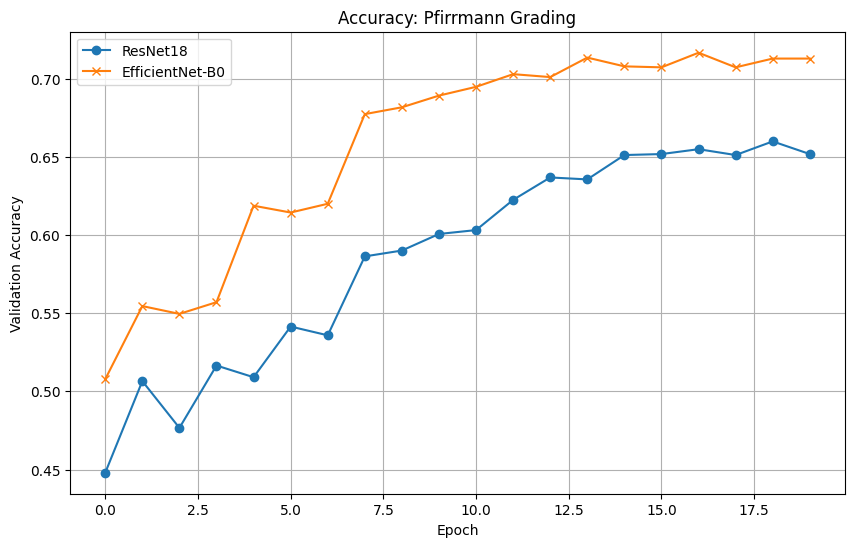

✅ Zapisano macierz pomyłek: /content/drive/MyDrive/colab_data/spider_results/grading_classification/confusion_matrix_resnet.png


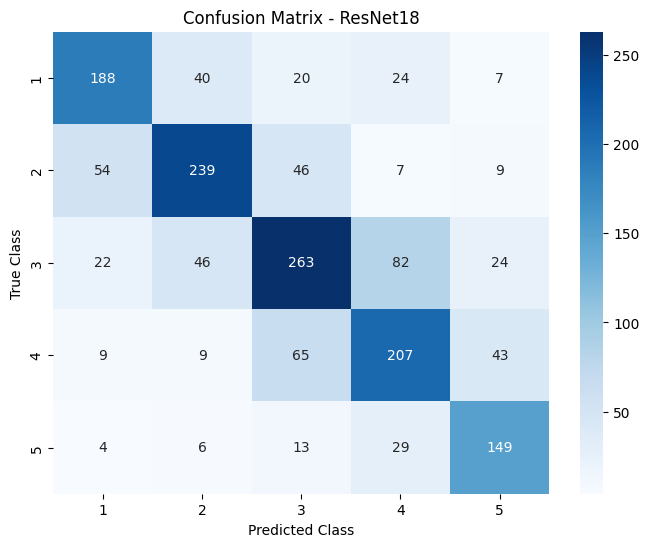

✅ Zapisano raport tekstowy.


In [22]:
from google.colab import drive
import os

RESULTS_DIR = '/content/drive/MyDrive/colab_data/spider_results/'

os.makedirs(os.path.join(RESULTS_DIR, 'localization_yolo'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'grading_classification'), exist_ok=True)

from ultralytics import YOLO
import glob
import shutil
import cv2
import random

# === CONFIFURATIOn ===
YOLO_MODEL_PATH = 'runs/detect/spider_yolo_final/weights/best.pt'
VAL_IMAGES_DIR = './datasets/spider_yolo/val/images'
SAVE_DIR = os.path.join(RESULTS_DIR, 'localization_yolo')

if not os.path.exists(YOLO_MODEL_PATH):
    list_of_files = glob.glob('runs/detect/*/weights/best.pt')
    if list_of_files:
        YOLO_MODEL_PATH = max(list_of_files, key=os.path.getmtime)

print(f"Using: {YOLO_MODEL_PATH}")
model = YOLO(YOLO_MODEL_PATH)
# 10 random images from valid
all_val_images = glob.glob(os.path.join(VAL_IMAGES_DIR, '*.jpg'))
selected_images = random.sample(all_val_images, min(10, len(all_val_images)))

print(f"Zapisywanie 10 przykładów detekcji do: {SAVE_DIR} ...")

for img_path in selected_images:
    filename = os.path.basename(img_path)

    results = model.predict(img_path, conf=0.25, save=True)

    save_dir_yolo = results[0].save_dir
    generated_img_path = os.path.join(save_dir_yolo, filename)

    target_path = os.path.join(SAVE_DIR, f"prediction_{filename}")
    shutil.copy(generated_img_path, target_path)

training_charts = glob.glob(os.path.dirname(YOLO_MODEL_PATH) + '/../*.png')
for chart in training_charts:
    shutil.copy(chart, os.path.join(SAVE_DIR, os.path.basename(chart)))

print("✅ YOLO results saved.")

import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

SAVE_DIR_GRADING = os.path.join(RESULTS_DIR, 'grading_classification')

# === 1. Save comparative image ===
plt.figure(figsize=(10, 6))
if 'hist_resnet' in locals():
    plt.plot(hist_resnet, label='ResNet18', marker='o')
if 'hist_effnet' in locals():
    plt.plot(hist_effnet, label='EfficientNet-B0', marker='x')

plt.title('Accuracy: Pfirrmann Grading')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

plot_path = os.path.join(SAVE_DIR_GRADING, 'comparison_accuracy_plot.png')
plt.savefig(plot_path)
print(f"✅ Zapisano wykres dokładności: {plot_path}")
plt.show()

# === 2. CONFUSION MATRIX ===
best_model = resnet
best_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(DEVICE)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
class_names = base_dataset.classes # ['1', '2', '3', '4', '5']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - ResNet18')

# save on Drive
cm_path = os.path.join(SAVE_DIR_GRADING, 'confusion_matrix_resnet.png')
plt.savefig(cm_path)
plt.show()

# Save classification report
report = classification_report(y_true, y_pred, target_names=class_names)
with open(os.path.join(SAVE_DIR_GRADING, 'classification_report.txt'), 'w') as f:
    f.write(report)

# Confusion matrix EffNet

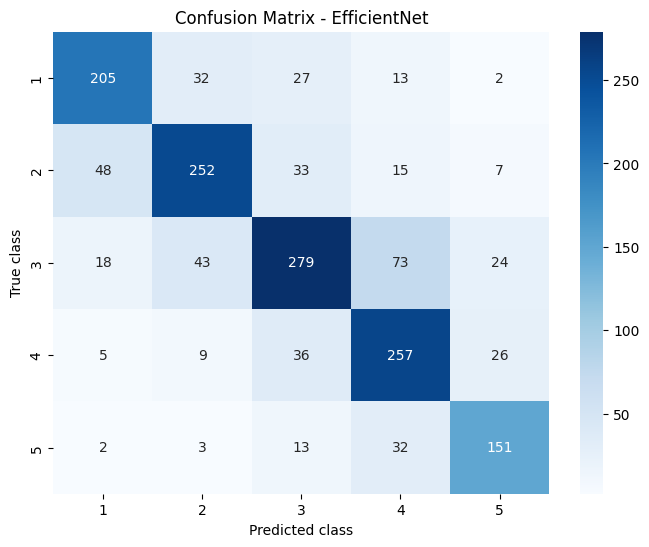

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

SAVE_DIR_GRADING = os.path.join(RESULTS_DIR, 'grading_classification')

# === CONFUSION MATRIX for EFFICIENTNET ===
best_model = effnet
best_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(DEVICE)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
class_names = base_dataset.classes # ['1', '2', '3', '4', '5']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix - EfficientNet')

cm_path = os.path.join(SAVE_DIR_GRADING, 'confusion_matrix_efficientnet.png')
plt.savefig(cm_path)
plt.show()

# 6. Report

-> Analiza YOLO: 172_t1_slice16...
-> Klasyfikacja EfficientNet dla 6 dysków...
-> Generowanie PDF...
✅ Raport gotowy: Raport_Pacjenta.pdf


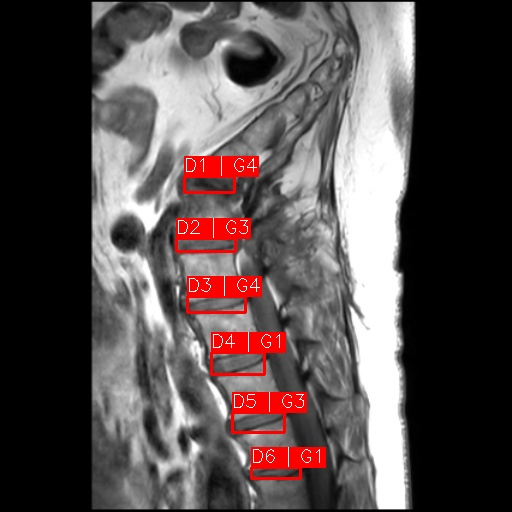

In [25]:
import os
import cv2
import torch
import numpy as np
from PIL import Image as PILImage
from fpdf import FPDF
from torchvision import transforms
from datetime import datetime

# === Conf for EFFICIENTNET ===
grading_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# pfirmann classes
GRADE_CLASSES = ['G1', 'G2', 'G3', 'G4', 'G5']

class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Intervertebral Disc Analysis Report', 0, 1, 'C')
        self.ln(5)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Generated on {datetime.now().strftime("%Y-%m-%d %H:%M")} | AI Assisted Diagnosis', 0, 0, 'C')

def generate_medical_report(image_path, yolo_model, grading_model, output_pdf_path="report.pdf"):
    """
    Creates report
    """
    # 1. Image
    img_cv = cv2.imread(image_path)
    if img_cv is None:
        print(f"Błąd: Nie można wczytać {image_path}")
        return

    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    h_img, w_img, _ = img_cv.shape
    case_id = os.path.basename(image_path).split('.')[0]

    # 2. YOLO detection
    print(f"-> Analiza YOLO: {case_id}...")
    results = yolo_model.predict(image_path, conf=0.25, verbose=False)[0]
    boxes = results.boxes.data.cpu().numpy()
    disc_id = 2
    for k, v in yolo_model.names.items():
        if 'disc' in v.lower(): disc_id = k

    # sorting
    disc_boxes = [b for b in boxes if int(b[5]) == disc_id]
    disc_boxes.sort(key=lambda x: x[1])

    if not disc_boxes:
        print("Nie znaleziono dysków!")
        return
    disc_metrics = []

    # 3. Grading + Drawing
    print(f"-> Klasyfikacja EfficientNet dla {len(disc_boxes)} dysków...")
    grading_model.eval()
    annotated_img = img_cv.copy()

    with torch.no_grad():
        for i, box in enumerate(disc_boxes):
            x1, y1, x2, y2 = map(int, box[:4])
            pad_x = int((x2-x1)*0.1)
            pad_y = int((y2-y1)*0.1)
            cx1 = max(0, x1-pad_x); cx2 = min(w_img, x2+pad_x)
            cy1 = max(0, y1-pad_y); cy2 = min(h_img, y2+pad_y)

            # (Crop)
            crop = img_rgb[cy1:cy2, cx1:cx2]
            pil_crop = PILImage.fromarray(crop)

            # Transform and pred
            input_tensor = grading_transforms(pil_crop).unsqueeze(0).to(DEVICE)
            outputs = grading_model(input_tensor)
            _, pred_idx = torch.max(outputs, 1)
            grade = GRADE_CLASSES[pred_idx.item()]
            height_px = y2 - y1
            depth_px = x2 - x1
            ratio = height_px / depth_px if depth_px > 0 else 0

            # Save
            disc_label = f"D{i+1}"
            disc_metrics.append([disc_label, grade, f"{height_px} px", f"{depth_px} px", f"{ratio:.3f}"])

            # Drawing on image
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            label_text = f"{disc_label} | {grade}"
            (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            cv2.rectangle(annotated_img, (x1, y1 - 20), (x1 + w, y1), (0, 0, 255), -1)
            cv2.putText(annotated_img, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    temp_img_path = "temp_annotated.jpg"
    cv2.imwrite(temp_img_path, annotated_img)

    # 4. PDF
    print("-> Generowanie PDF...")
    pdf = PDFReport()
    pdf.add_page()

    # Info section
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(0, 10, f'Case ID: {case_id}', 0, 1)
    pdf.ln(5)

    pdf.set_font('Arial', 'B', 14)
    pdf.cell(0, 10, 'Sagittal MRI with Disc Localization and Grading', 0, 1)
    pdf.ln(5)

    # Put image
    pdf.image(temp_img_path, x=35, w=140)
    pdf.ln(10)

    # Table
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(0, 10, 'Quantitative Disc Metrics', 0, 1)
    pdf.ln(5)

    pdf.set_font('Arial', 'B', 10)
    pdf.set_fill_color(200, 200, 200)
    col_width = 35
    headers = ['Disc ID', 'Pfirrmann Grade', 'Height', 'Depth', 'H/D Ratio']

    for header in headers:
        pdf.cell(col_width, 10, header, 1, 0, 'C', 1)
    pdf.ln()
    pdf.set_font('Arial', '', 10)
    for row in disc_metrics:
        for item in row:
            pdf.cell(col_width, 10, str(item), 1, 0, 'C')
        pdf.ln()

    pdf.output(output_pdf_path)
    print(f"✅ Report ready: {output_pdf_path}")

    from IPython.display import display, Image
    display(Image(filename=temp_img_path))

# === RUN ===
import glob
val_images = glob.glob('./datasets/spider_yolo/val/images/*.jpg')
test_img_path = val_images[0]
effnet = effnet.to(DEVICE)

generate_medical_report(test_img_path, model, effnet, "Pacient_report.pdf")

In [ ]:
n
